In [83]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential, load_model
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import itertools
from python_speech_features import mfcc, logfbank
import librosa
from sklearn.metrics import confusion_matrix
import librosa

In [84]:
class Config:
    def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=512, rate=16000):
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/10)

In [85]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [86]:
def build_rand_feat():
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    print('tqdm: ',n_samples)
    for _ in tqdm(range(int(n_samples))):
        rand_class = np.random.choice(class_dist.index, p = prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate, wav = wavfile.read('clean_voice/'+file)
        label = df.at[file, 'label']
        rand_index = np.random.randint(0, wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        X_sample = mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        X.append(X_sample if config.mode == 'conv' else X_sample.T)
        y.append(classes.index(label))
    X, y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    y = to_categorical(y, num_classes=8)
    return X, y, _min, _max

In [87]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods = 1, center = True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [88]:
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return(Y, freq)

In [89]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=4, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(4):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

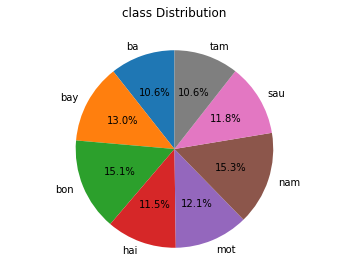

3__l106.wav
7__l334.wav
4__l149.wav
l65.wav
chunk38.wav
5__l25.wav
6__l162.wav
8__1l221.wav


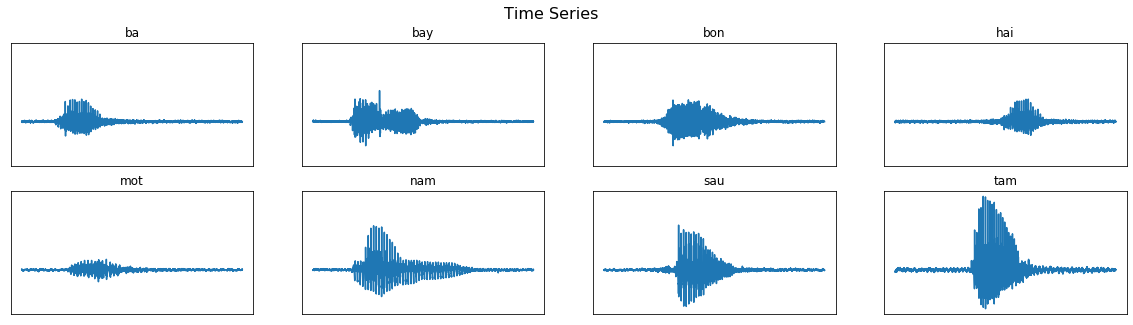

In [90]:
df = pd.read_csv('voice_label.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('clean_voice/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

fig, ax = plt.subplots()
ax.set_title('class Distribution', y=1.08)
ax.pie(class_dist, labels = class_dist.index, autopct='%1.1f%%', shadow=False, startangle=90)
ax.axis('equal')
plt.show()
df.reset_index(inplace=True)

signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes:
    wav_file = df[df.label == c].iloc[0,0]
    print(wav_file)
    signal, rate = librosa.load('clean_voice/'+wav_file, sr=44100)
    mask = envelope(signal, rate, 0.0005)
    signal = signal[mask]
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)

    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
    fbank[c] = bank
    mel = mfcc(signal[:rate], rate, numcep = 13, nfilt=26, nfft = 1103).T
    mfccs[c] = mel
    
plot_signals(signals)
plt.show()

4__l149.wav
['ba', 'bay', 'bon', 'hai', 'mot', 'nam', 'sau', 'tam']
6760.0


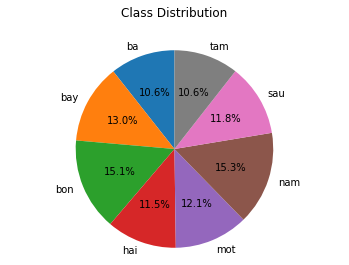

In [91]:
df = pd.read_csv('voice_label.csv')
df.set_index('fname', inplace=True) #danh so thu tu tung file
print(df.index[0])
for f in df.index:
    rate, signal = wavfile.read('clean_voice/'+f)  #tan so lay mau(rate=16000) va so mau moi file
    df.at[f, 'length'] = signal.shape[0]/rate  #tgian s

classes = list(np.unique(df.label))
print(classes)
class_dist = df.groupby(['label'])['length'].mean()

n_samples = 2*int(df['length'].sum())/0.1
print(n_samples)
prob_dist = class_dist/class_dist.sum()
choices = np.random.choice(class_dist.index, p = prob_dist)

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

config = Config(mode='conv')

In [92]:
X, y, _min, _max = build_rand_feat()

  1%|          | 69/6760 [00:00<00:09, 687.33it/s]

tqdm:  6760.0


100%|██████████| 6760/6760 [00:09<00:00, 728.17it/s]


In [95]:
y_flat = np.argmax(y, axis=1)
input_shape = (X.shape[1], X.shape[2], 1)

In [96]:
class_weight = compute_class_weight('balanced',np.unique(y_flat),y_flat)
print('class_weight: ',class_weight)

class_weight:  [1.13 0.97 0.82 1.17 1.04 0.82 1.04 1.16]


In [97]:
# print(list(X[0][0][0]))
# print(list(X[0][0][1]))
print(X.shape)
print(X)
print(X[0].dtype)
a = list(X[0])
# for i in X[0]:
#     for j in X[0][X[0].index(i)]:
#         print(j)

(6760, 13, 9, 1)
[[[[0.53]
   [0.53]
   [0.53]
   ...
   [0.53]
   [0.54]
   [0.54]]

  [[0.44]
   [0.44]
   [0.43]
   ...
   [0.44]
   [0.56]
   [0.59]]

  [[0.58]
   [0.58]
   [0.54]
   ...
   [0.56]
   [0.69]
   [0.71]]

  ...

  [[0.55]
   [0.54]
   [0.62]
   ...
   [0.54]
   [0.55]
   [0.59]]

  [[0.61]
   [0.54]
   [0.54]
   ...
   [0.58]
   [0.49]
   [0.47]]

  [[0.57]
   [0.54]
   [0.61]
   ...
   [0.57]
   [0.55]
   [0.6 ]]]


 [[[0.57]
   [0.57]
   [0.57]
   ...
   [0.56]
   [0.57]
   [0.56]]

  [[0.6 ]
   [0.59]
   [0.57]
   ...
   [0.61]
   [0.59]
   [0.59]]

  [[0.37]
   [0.39]
   [0.44]
   ...
   [0.59]
   [0.59]
   [0.59]]

  ...

  [[0.44]
   [0.52]
   [0.63]
   ...
   [0.68]
   [0.55]
   [0.52]]

  [[0.48]
   [0.51]
   [0.55]
   ...
   [0.61]
   [0.6 ]
   [0.59]]

  [[0.63]
   [0.59]
   [0.52]
   ...
   [0.53]
   [0.55]
   [0.62]]]


 [[[0.53]
   [0.53]
   [0.53]
   ...
   [0.53]
   [0.54]
   [0.53]]

  [[0.46]
   [0.44]
   [0.45]
   ...
   [0.47]
   [0.45]
   [0.43]]


In [104]:
model = load_model('voice_conv.h5')

In [105]:
 y_pred = model.predict(X)

ValueError: Error when checking input: expected conv2d_17_input to have shape (9, 13, 1) but got array with shape (13, 9, 1)

In [99]:
print(y_pred.shape)
print(y_pred)

(6760, 8)
[[0.11 0.12 0.15 ... 0.15 0.12 0.11]
 [0.11 0.12 0.15 ... 0.15 0.12 0.11]
 [0.11 0.12 0.15 ... 0.15 0.12 0.11]
 ...
 [0.11 0.12 0.15 ... 0.15 0.12 0.11]
 [0.11 0.12 0.15 ... 0.15 0.12 0.11]
 [0.11 0.12 0.15 ... 0.15 0.12 0.11]]


In [40]:
y0 = model.predict(X[0])
print(y0)

ValueError: Error when checking input: expected lstm_41_input to have 3 dimensions, but got array with shape (9, 13)

In [100]:
print(y_pred.shape)

(6760, 8)


In [101]:
cfm = confusion_matrix(np.argmax(y,axis=1), np.argmax(y_pred, axis=1))

In [102]:
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[   0    0  749    0    0    0    0    0]
 [   0    0  875    0    0    0    0    0]
 [   0    0 1027    0    0    0    0    0]
 [   0    0  721    0    0    0    0    0]
 [   0    0  811    0    0    0    0    0]
 [   0    0 1035    0    0    0    0    0]
 [   0    0  813    0    0    0    0    0]
 [   0    0  729    0    0    0    0    0]]


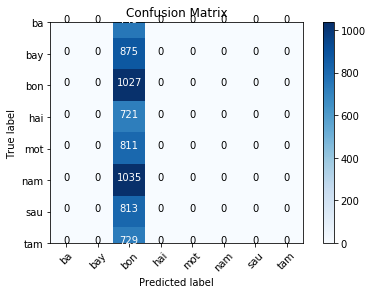

In [103]:
plt.figure()
class_names = ['ba', 'bay', 'bon', 'hai', 'mot', 'nam', 'sau', 'tam']
plot_confusion_matrix(cfm, classes=class_names, title='Confusion Matrix')
plt.show()